<a href="https://colab.research.google.com/github/blueeagle100/3d_bounding_boxes/blob/main/3d_box_stereo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3D Bounding Boxes from LiDAR Point Cloud Data**

In this tutorial we will learn how to draw 3D bounding boxes on detected objects. The high level pipeline will be:
- In the camera images, detect objects in 2D 
- Project LiDAR Depth information on the object 
- Get 3D location of object in image/camera space
- Draw 3D bounding box


Once again, the KITTI dataset is located [here]()http://www.cvlibs.net/datasets/kitti/raw_data.php a readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT). A paper that details the data collection can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)



### **Download the Data**
Let's donwload the data, I am using the raw city data (2011_09_26_drive_0106_sync).

This data is synced and rectified, which is very important for this excercise

In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip

--2022-08-31 16:16:53--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.140.111
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.140.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 936875950 (893M) [application/zip]
Saving to: ‘2011_09_26_drive_0106_sync.zip.1’

2011_09_26_drive_01 100%[===================>] 893.47M  28.4MB/s    in 33s     

2022-08-31 16:17:26 (27.3 MB/s) - ‘2011_09_26_drive_0106_sync.zip.1’ saved [936875950/936875950]



And now we will download the corresponding calibration file which contains several transformation matrices that we will need

In [3]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip

--2022-08-31 16:17:26--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.139
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘2011_09_26_calib.zip.1’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2022-08-31 16:17:27 (66.6 MB/s) - ‘2011_09_26_calib.zip.1’ saved [4068/4068]



In [4]:
!jar xf 2011_09_26_drive_0106_sync.zip

In [5]:
!jar xf 2011_09_26_calib.zip

In our data folder we have images from 2 gray stereo cameras and 2 color stereo cameras. We also have LiDAR point clouds and GPS and IMU data. The LiDAR used in the KITTI dataset is a Velodyne LiDAR, so the variables that refer to 'velo' actually refer to the LiDAR point cloud.

Just as in part1, we will use data from the 2 color cameras. The folder labeled "image_02" corresponds to the left camera and "image_03" corresponds to the right camera.

#### Base Library Import

In [6]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### **Get data**

In [7]:
DATA_PATH = r'2011_09_26/2011_09_26_drive_0106_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")

Number of left images: 227
Number of right images: 227
Number of LiDAR point clouds: 227


### **Get Camera Calibration Data**

Here we will get calibration data for both color cameras, and we will get the rotation and trnaslation matrix for LiDAR to camera frame of reference.


In [8]:
with open('2011_09_26/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

In [9]:
def decompose_projection_matrix(P):    
    K, R, T, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
    T = T/T[3]

    return K, R, T

In [10]:
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

Once again: the projection matrices will be decomposed into:
 - The Intrinsic Calibration Matrix (K) 
 - The rotation Matrix (R)
 - The translation Matrix (T)

## **Create Stereo Depth Pipeline**

In [11]:
# set number of disparities
NUM_DISPARITIES = 96

In [12]:
def compute_sgbm_disparity(left_image, right_image, num_disparities=5*16, 
                           block_size=11, window_size=5, display=False):
    """ Computes the disparity of an image pair using the SGBM algoithm.
        Inputs: 
            image_left/_right - (MxN) grayscale input images
            see opencv documentation for "StereoBM_create"
        Outputs:
            disparity (MxN) computed disparity map for the input images
        
        NOTE: image_left must be the left image (same for the right) or 
              unexpected results will occur due to 
    """
    # P1 and P2 control disparity smoothness (recommended values below)
    P1 = 8 * 3 * window_size**2
    P2 = 32 * 3 * window_size**2
    sgbm_obj = cv2.StereoSGBM_create(0, num_disparities, block_size, 
        P1, P2, mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
        
    # compute disparity
    disparity = sgbm_obj.compute(left_image, right_image).astype(np.float32)/16.0

    # display is desired
    if display:
      plt.figure(figsize = (40,20))
      plt.imshow(disparity, cmap='cividis')
      plt.title('Disparity Map', size=25)
      plt.show();

    return disparity

In [13]:
def calc_depth_map(disp_left, K_left, T_left, T_right):
    ''' Computes Depth map from Intrinsic Camera Matrix and Translations vectors.
        For KITTI, the depth is in meters.
        '''
    # Get the focal length from the K matrix
    f = K_left[0, 0]
    
    # Get the distance between the cameras from the t matrices (baseline)
    b = np.abs(T_left[0] - T_right[0])[0]
    
    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left <= 0] = 1e-5
    
    # Calculate the depths 
    depth_map = f*b / disp_left 

    return depth_map

## **Get Object Detection Pipeline**

Just like part 1, we will use yolov5

In [14]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [16]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-31 Python-3.7.13 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [17]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

In [45]:
def get_distances(image, depth_map, bboxes, method='median', draw=True):
    ''' Obtains distance measurements for each detected object in the image 
        Inputs:
          image - input image for detection 
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          method - distance metric (median or center)
        Outputs:
          image - input image with distances drawn at the center of each 
                  bounding box
          bboxes_out - updated bboxes to inluve (u,v,z) object center locations
        '''

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()
        
        # get center location on image
        x_center = np.round((pt1[1] + pt2[1]) / 2).astype(int)
        y_center = np.round((pt1[0] + pt2[0]) / 2).astype(int)

        # get depth slice
        depth_slice = depth_map[pt1[1]:pt2[1], pt1[0]:pt2[0]]

        # compute median depth to get the distance
        if method == 'center':
            x_c = np.round((pt2[1] - pt1[1]) / 2).astype(int)
            y_c = np.round((pt2[0] - pt1[0]) / 2).astype(int)
            stereo_depth = depth_slice[x_c, y_c]
        else:
            stereo_depth = np.median(depth_slice)

        # draw depth on image at center of each bounding box
        if draw:
            cv2.putText(image, 
                        '{0:.2f} m'.format(stereo_depth), 
                        (y_center, x_center),
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, 
                        (255, 0, 0), 2, cv2.LINE_AA)    

        # add object_center (u, v, z) to bboxes
        bboxes_out[i, -3:] = np.array([x_center, y_center, stereo_depth])
        
    return image, bboxes_out

In [46]:
def get_depth_detections(left_image, right_image, method='median', 
                         draw_boxes=True, draw_depth=True):
    ''' Obtains detections depth estimates for all objects in the input stereo 
        pair. The images are assumed to have already been rectified. Parameters 
        in 'compute_sgbm_disparity' will need to be tuned.
        '''
    # convert to grayscale
    left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
    right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)

    ## 1. compute left disparity map
    disparity = compute_sgbm_disparity(left_image_gray, 
                                       right_image_gray, 
                                       num_disparities=NUM_DISPARITIES, 
                                       block_size=7, 
                                       window_size=7)

    ## 2. compute left depth map
    depth_map = calc_depth_map(disparity, K_left, T_left, T_right)

    # filter depth map
    filtered_depth_map = cv2.medianBlur(depth_map, 5)

    ## 3. compute detections in the left image
    detections = model(left_image)

    # draw boxes on image
    if draw_boxes:
        detections.show() 

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0]

    # get distance measurements for image
    left_image, bboxes = get_distances(left_image, 
                                       filtered_depth_map, 
                                       bboxes, 
                                       method, 
                                       draw_depth)

    return left_image, disparity, filtered_depth_map, bboxes

## **Test the base pipeline**

In [84]:
index = 20

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(right_image_paths[index]), cv2.COLOR_BGR2RGB)

left_image, left_disparity, filtered_depth_map, bboxes = get_depth_detections(
                                                          left_image, 
                                                          right_image, 
                                                          method='center',
                                                          draw_boxes=True, 
                                                          draw_depth=True)

### Display results

In [21]:
from matplotlib import cm

# get color map function
nipy_spectral = cm.get_cmap('nipy_spectral') 

In [22]:
# get depth map
depth_map = (255*nipy_spectral(filtered_depth_map.round().astype(int))).astype(np.uint8)

# reverse to rgb and remove transparency
depth_map = depth_map[:, :, ::-1][:, :, 1:] 

# stack frames
stacked = np.vstack((left_image, depth_map))

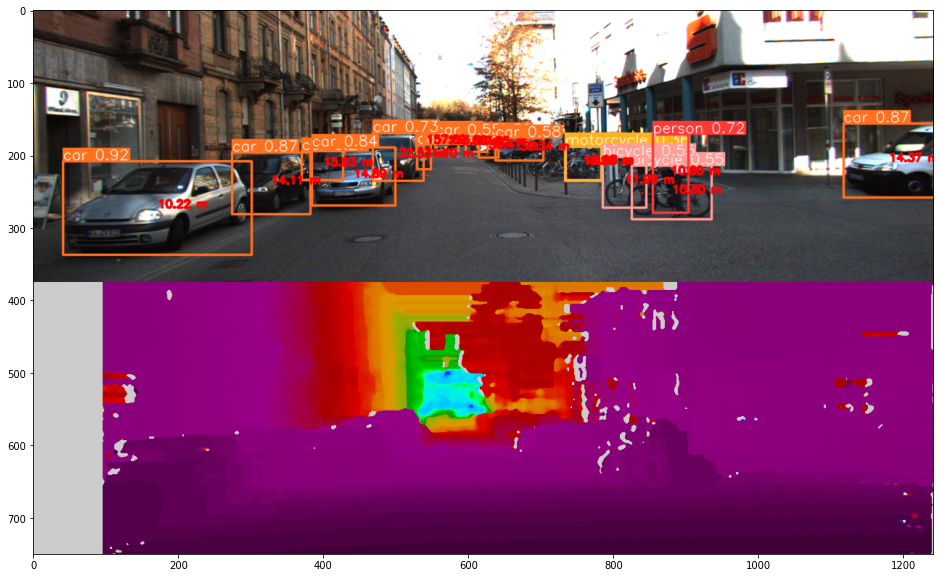

In [23]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

plt.imshow(stacked);

## **Convert image and Depth Map to point cloud array**

OpenCV uses the Q Matrix is used to get a 3D Point Cloud.
If you've done the calibration notebook, you saw this Q matrix as "disparity to depth".

**Structure of the Q Matrix:**<p>
![](https://answers.opencv.org/upfiles/15222662547364629.png)

It is obstained through stereo calibration, in particular, the function
```
Q = np.zeros(4,4)
cv2. stereoRectify (cameraMatrixLeft, CameraMatrixRight, distortion_coefficients_left, distortion_coefficients_right, image_size, R, T, R1, R2, P1, P2, Q)
```

Then, StereoRectify modifies the Q matrix.

**It then can be used the following:**<p>
![](https://answers.opencv.org/upfiles/1522266963686882.png)


In [88]:
# Calculate depth-to-disparity
cam1 = P_left[:, :3] # left image - P2
cam2 = P_right[:, :3] # right image - P3

# Tmat = np.array([0.54, 0., 0.]) #On the setup page, you can see 0.54 as the distance between the two color cameras (http://www.cvlibs.net/datasets/kitti/setup.php)
Tmat = T_right[:3]

Q = np.zeros((4,4))

cv2.stereoRectify(cameraMatrix1=cam1, cameraMatrix2=cam2, \
                  distCoeffs1=0, distCoeffs2=0, \
                  imageSize=left_image.shape[:2], \
                  R=np.identity(3), T=Tmat, \
                  R1=None, R2=None, \
                  P1= None, P2= None, Q=Q);

print("Disparity To Depth")
print(Q)

Disparity To Depth
[[          1           0           0     -617.73]
 [          0           1           0     -173.48]
 [          0           0           0      721.54]
 [          0           0     -2.1147           0]]


## Now project the image to 3D
See https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga1bc1152bd57d63bc524204f21fde6e02

In [89]:
# project image to 3D
points = cv2.reprojectImageTo3D(left_disparity.copy(), Q)


#reflect on x axis
reflect_matrix = np.identity(3)
reflect_matrix[0] *= -1
points = np.matmul(points, reflect_matrix)

# clip large points to due disparity and noise
# points = np.clip(points, -2000, 2000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


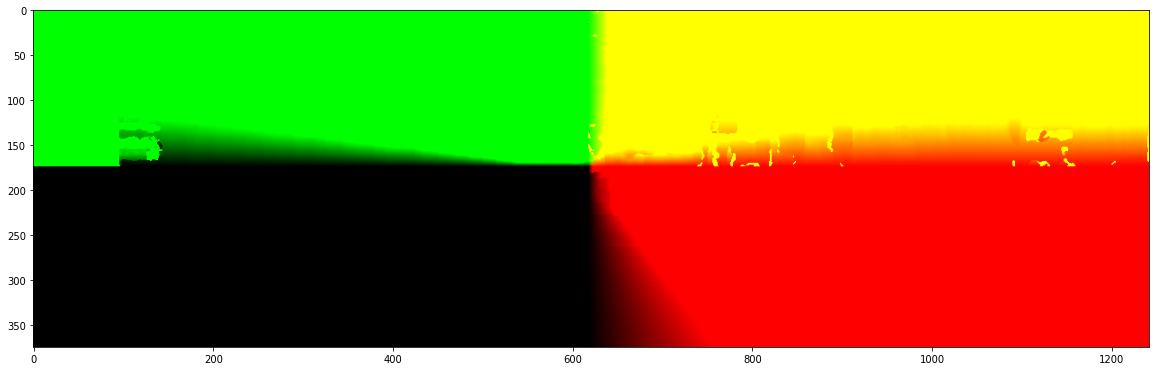

In [90]:
plt.imshow(points)

In [54]:
img_h, img_w = left_image.shape[:2]

np.mgrid[0:img_w, 0:img_h]

img_w, img_h

(1242, 375)

In [55]:
(x_vals, y_vals) = np.mgrid[0:img_h, 0:img_w]

In [77]:
img_h/2, img_w /2

(187.5, 621.0)

In [78]:
# or just use basic stereo equations?
b = T_right[0]
x = b*(x_vals - 621)/left_disparity
y = b*(y_vals - 187)/left_disparity

In [91]:
x[212, 314]

-7.8538407945601065

In [92]:
y[212, 314]

2.438723180706928

In [93]:
filtered_depth_map[212, 314]

15.569488

In [94]:
points[212, 314]

array([    -5.8325,     -0.7397,     -13.856])

In [152]:
# [X Y Z 1] = inv(K)* [Z*x Z*y Z]
tmp = np.linalg.inv(K_left) @ np.array([filtered_depth_map[212, 314]*212, filtered_depth_map[212, 314]*314, filtered_depth_map[212, 314]])

In [153]:
tmp

array([    -8.5786,      3.0457,      15.569])

In [154]:
# [x y 1] = 1/Z * K * [X Y Z 1]
K_left_homo = np.hstack((K_left, np.zeros((3, 1))))
tmp2 = 1/filtered_depth_map[212, 314] * K_left_homo @ np.array([-8.5786, 3.0457, 15.569, 1])

In [155]:
tmp2

array([     211.98,         314,     0.99997])

In [156]:
Z = filtered_depth_map.copy()

In [165]:
(u, v) = np.mgrid[0:img_h, 0:img_w]

x_vals = (u*Z).reshape((-1, 1))
y_vals = (v*Z).reshape((-1, 1))
z_vals = Z.reshape((1, -1))

In [ ]:
tmp3 = np.linalg.inv(K_left) @ np.array([x_vals, y_vals, z_vals])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
np.hstack([x_vals, y_vals, z_vals])

In [138]:
np.linalg.inv(K_left).shape

(3, 3)

In [136]:
tmp = np.linalg.inv(K_left) @ np.vstack([[filtered_depth_map * x_vals, filtered_depth_map * y_vals, filtered_depth_map]])

ValueError: ignored

In [140]:
np.einsum('cg,gmn->gmn', np.linalg.inv(K_left), np.vstack([[filtered_depth_map * x_vals, filtered_depth_map * y_vals, filtered_depth_map]])).shape

(3, 375, 1242)

In [124]:
(filtered_depth_map * x_vals).shape

(375, 1242)

In [108]:
tmp[212, 314]

array([[    -3.7266],
       [    0.49357],
       [     9.0976]])

In [114]:
np.array([[-3.7266,  0.49357, 9.0976, 1]]).T.shape

(4, 1)

In [118]:
K_left

array([[     721.54,           0,      609.56],
       [          0,      721.54,      172.85],
       [          0,           0,           1]])

In [120]:
K_left_homo = np.hstack((K_left, np.zeros((3, 1))))

In [129]:
tmp.shape

(1242, 375, 3, 1)

In [128]:
K_left_homo @ tmp

ValueError: ignored

In [127]:
1/filtered_depth_map * K_left_homo @ tmp

ValueError: ignored

In [121]:
|1/filtered_depth_map * K_left_homo @ np.array([[-3.7266,  0.49357, 9.0976, 1]]).T

ValueError: ignored

In [ ]:

#extract colors from image
#img_left_color = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
#colors = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)
img_left = cv2.imread(images_L[index])
colors = cv2.cvtColor(img_left.copy(),cv2.COLOR_BGR2RGB)

#filter by min disparity
mask = left_disparity > left_disparity.min()
out_points = points[mask]
out_colors = left_image[mask]

#filter by dimension
#idx = np.fabs(out_points[:,0]) < 4.5
#out_points = out_points[idx]
out_colors = out_colors.reshape(-1, 3)
#out_colors = out_colors[idx]

In [48]:
bboxes

array([[     41.952,      208.31,      301.98,      337.09,       0.923,           2,         272,         172,      10.216],
       [     1117.5,      156.73,        1242,      258.48,     0.86962,           2,         208,        1180,      14.369],
       [     274.72,      196.44,       382.2,      281.78,     0.86701,           2,         239,         328,      14.105],
       [     384.43,      189.91,      499.16,      269.61,       0.836,           2,         230,         442,      14.891],
       [     468.99,      169.73,      538.64,      235.41,      0.7307,           2,         202,         504,      22.527],
       [     854.05,      171.29,      903.68,      279.84,     0.71825,           0,         226,         879,      10.603],
       [     637.94,      176.15,      703.85,      207.86,     0.58247,           2,         192,         671,      35.345],
       [     554.88,      173.74,      586.53,      194.15,     0.55197,           2,         184,         571,      1

In [52]:
points[211, 760]

array([     3.2918,    -0.86812,     -16.695])

In [39]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2, min_samples=20)
dbscan.fit(points.reshape(-1, 3)[:1000, :])

DBSCAN(eps=2, min_samples=20)

In [ ]:
# draw clusters on new image
labels = dbscan.labels_
print(np.unique(labels))

pastel = cm.get_cmap('Pastel2')
get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

# unpack LiDAR points
u, v, z = velo_camera

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(u)):
    cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
              get_pastel(labels[i]), -1);

## **Lets move on to extracting 3D point cloud objects**

First we need to run the RANSAC algorithm to remove the plane. But we will need to use the points the LiDAR frame of reference, so we need a way of contiunously relating the image point cloud with the True LiDAR point cloud

Read points directly from bin file and use RANSAC to remove the ground plane

In [ ]:
velo_points = bin2h_velo(lidar_bin, remove_plane=True)

Now let's run K-means clustering in LiDAR space to get object clusters. First we will seed K-means with the centers of the detected objects

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=bboxes_out.shape[0])
# kmeans.init()
kmeans.fit(velo_points[:3, :].T)

KMeans(n_clusters=17)

In [ ]:
velo_cam = velo2camera(velo_points, left_image, remove_outliers=True)

In [ ]:
# draw clusters on new image
labels = kmeans.labels_
print(np.unique(labels))

pastel = cm.get_cmap('Pastel2')
get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

# unpack LiDAR points
u, v, z = velo_cam

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(u)):
    cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
              get_pastel(labels[i]), -1);

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


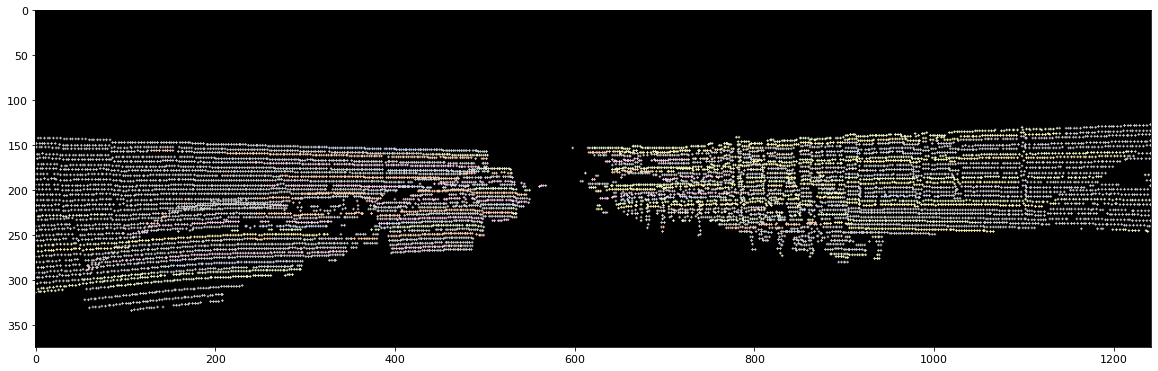

In [ ]:
plt.imshow(new_image);

Compare with DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2, min_samples=20)
dbscan.fit(velo_points[:3, :].T)

DBSCAN(eps=2, min_samples=20)

In [ ]:
labels = dbscan.labels_

# get clusters in LiDAR space


In [ ]:
# draw clusters on new image
labels = dbscan.labels_
print(np.unique(labels))

pastel = cm.get_cmap('Pastel2')
get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

# unpack LiDAR points
u, v, z = velo_camera

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(u)):
    cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
              get_pastel(labels[i]), -1);

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]


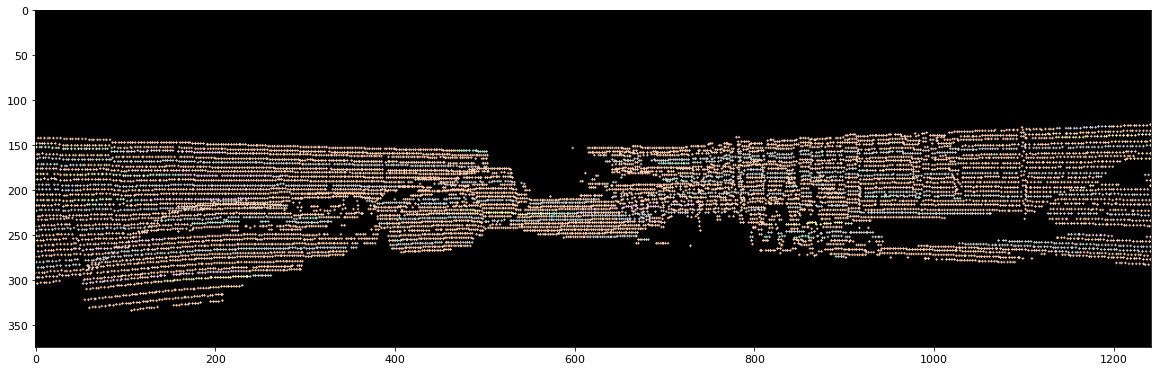

In [ ]:
plt.imshow(new_image);

In [ ]:
velo_points[:3, :]

array([[     76.942,      75.186,      73.536, ...,      14.955,      15.038,      15.174],
       [     11.739,      11.712,      11.691, ...,      -2.981,      -2.973,      -2.951],
       [      2.841,       2.782,       2.727, ...,      -6.995,      -7.032,      -7.092]], dtype=float32)

In [ ]:
# draw clusters on new image
labels = dbscan.labels_
print(np.unique(labels))

pastel = cm.get_cmap('Pastel2')
get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

# unpack LiDAR points
x, y, z = velo_points[:3, :]

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(z)):
    cv2.circle(new_image, (int(y[i] + 100), int(z[i]) + 100), 1, 
              get_pastel(labels[i]), -1);

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]


IndexError: ignored

In [ ]:
z.min()

-9.147

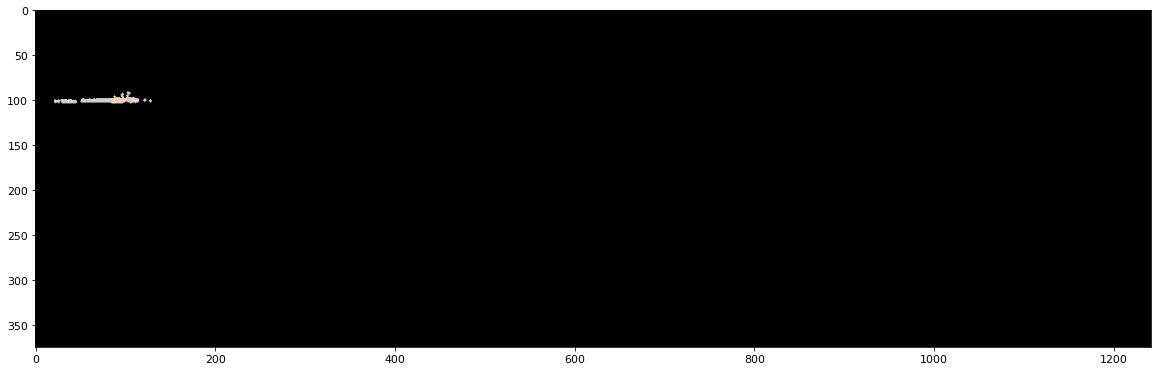

In [ ]:
plt.imshow(new_image)

In [ ]:
tmp = P_left @ R_left_rect @ T_cam_velo @ velo_points[:, labels == 0]
tmp[:2] /= tmp[2, :]
tmp.shape

(3, 37)

In [ ]:
np.mean(velo_points[:, labels == 0], axis=1)

array([     59.812,      11.271,      1.1148,           1], dtype=float32)

In [ ]:
tmp = P_left @ R_left_rect @ T_cam_velo @ np.mean(velo_points[:, labels == 0], axis=1)
tmp[:2] /= tmp[2]
tmp

array([     477.15,      170.56,      59.605])

In [ ]:
arr = np.array([477.15, 170.56, 1]) 

In [ ]:
np.linalg.inv(R_left) @ np.linalg.inv(K_left) @ np.c_[arr] - T_left[:3]

array([[   -0.12366],
       [ -0.0035372],
       [     1.0027]])

In [ ]:
np.linalg.inv(R_left) @ np.c_[arr @ np.linalg.inv(K_left)] - T_left[:3]

array([[    0.72115],
       [    0.23603],
       [    -442.96]])

In [ ]:
np.linalg.inv(R_left).shape

(3, 3)

In [ ]:
T_left

array([[  -0.059849],
       [ 0.00035793],
       [ -0.0027459],
       [          1]])

In [ ]:
K_left

array([[     721.54,           0,      609.56],
       [          0,      721.54,      172.85],
       [          0,           0,           1]])

In [ ]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [ ]:
np.sum(labels == 5)

245

In [ ]:
new_points = velo2camera(velo_points[:, labels == 5], left_image)
new_points.shape

(3, 0)

In [ ]:
new_points.shape[1]

0

In [ ]:
# unpack LiDAR points
u, v, z = new_points

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(z)):
    cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
              get_pastel(z[i]), -1);

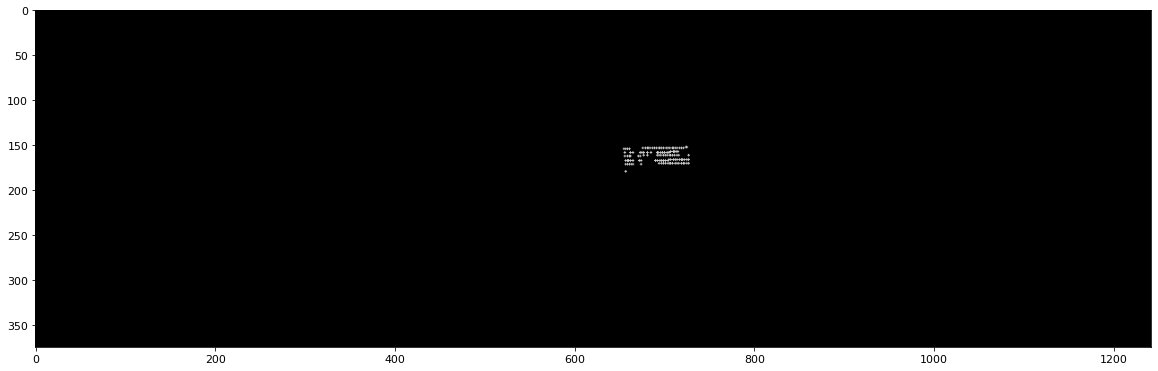

In [ ]:
plt.imshow(new_image)

In [ ]:
labels.shape

(74458,)

In [ ]:
def image_clusters_from_velo(velo_points, labels, image):
    ''' Obtains clusters in image space from velo (LiDAR) points 
        Inputs:
            velo_points (4xN) Homogeneous LiDAR points
            labels (N,) cluster labels (clusters formed in LiDAR space)
            image - reference image for transformation from LiDAR to image space
        Outputs:
            clusters (list) list that contains each cluster label and cluster
        '''
    clusters = []
    for label in np.unique(labels):
        # convert from velo to camera 
        velo_cam = velo2camera(velo_points[:, labels == label], image)
        
        # append cluster label and cluster to clusters
        if velo_cam.shape[1] > 0:
            clusters.append([label, velo_cam])

    return clusters

In [ ]:
def draw_clusters_on_image(image, clusters, draw_centroids=False):
    ''' draws the clusters on an image '''
    pastel = cm.get_cmap('Pastel2', lut=50)
    get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

    for cluster in clusters:
        label = cluster[0]
        for (u, v, z) in cluster[1].T:
            cv2.circle(image, (int(u), int(v)), 1, 
                       get_pastel(label), -1);

        if draw_centroids:
            centroid = np.mean(cluster[1], axis=1)
            cv2.circle(image, (int(centroid[0]), int(centroid[1])), 5, 
                       get_pastel(label), -1);

    return image


Read LiDAR data directly from bin file

In [ ]:
velo_points = bin2h_velo(lidar_bin, remove_plane=True)

In [ ]:
clusters = image_clusters_from_velo(velo_points, labels, left_image)

In [ ]:
new_image = np.zeros_like(left_image)
new_image = draw_clusters_on_image(new_image, clusters, draw_centroids=True)

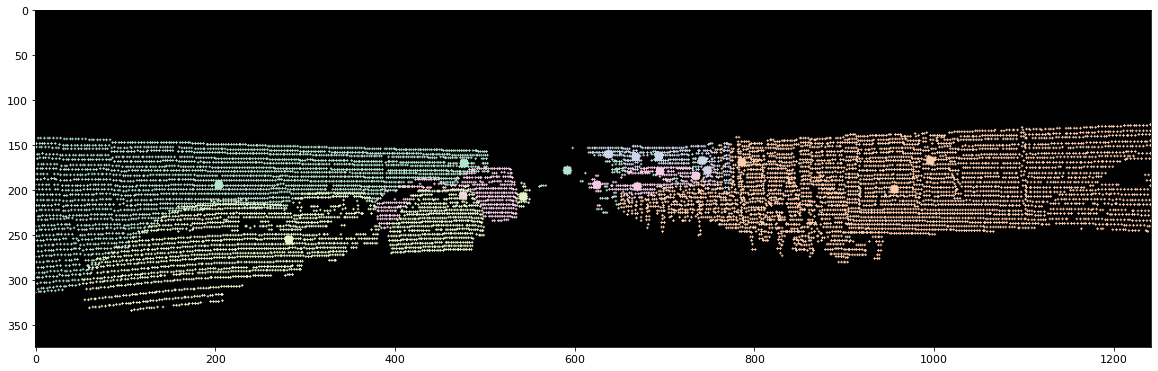

In [ ]:
plt.imshow(new_image)

In [ ]:
tmp = 
tmp[0]

-1

In [ ]:
clusters[15][1].min(axis=1)

array([     12.946,      3.8767,      47.189])

Convert camera reference to real world units
https://stackoverflow.com/questions/47054848/converting-pixel-width-to-real-world-width-in-millimeters-using-camera-calibrati

Camera calibration info
https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-for-camera-calibration-in-computer-vision/

Sensor size of cameras used
https://www.alliedvision.com/en/camera-selector/detail/manta/g-146/

compute camera sensor width: http://www.lightcrafttech.com/support/doc/lens-interface/camera-sensor/

TO get the width of the sensor in pixels we divide the physical width of the sensor (in meters) by the nuber of pixels along the horizonal axis

calculate pixel pitch: https://myelo.elotouch.com/support/s/article/How-to-Calculate-Pixel-Pitch

https://www.fdxlabs.com/calculate-x-y-z-real-world-coordinates-from-a-single-camera-using-opencv/

In [ ]:
focal_length = K_left[0, 0]

In [ ]:
sensor_width_pix = 1382

In [ ]:
!pip install open3d

In [ ]:
masked_velo_points[:3, :]

array([[     76.942,      75.186,      73.536, ...,      14.955,      15.038,      15.174],
       [     11.739,      11.712,      11.691, ...,      -2.981,      -2.973,      -2.951],
       [      2.841,       2.782,       2.727, ...,      -6.995,      -7.032,      -7.092]], dtype=float32)

In [ ]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()

xyz = np.asarray(masked_velo_points[:3, :].T)
pcd.points = o3d.utility.Vector3dVector(xyz)

In [ ]:
# cluster point cloud
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=20, 
                                         min_points=8, 
                                         print_progress=True))

In [ ]:
np.unique(labels)

NameError: ignored

In [ ]:
import copy

pcd2 = copy.deepcopy(pcd)

max_label = labels.max() + 1
colors = plt.get_cmap('tab20')(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd2.colors = o3d.utility.Vector3dVector(colors[:, :3])

In [ ]:
pcd2

PointCloud with 10310 points.

In [ ]:
def get_clusters_from_labels(pcd, labels, include_outliers=True):
    ''' Obtains a list of individual cluster point clouds and paints them 
        unique colors. Assumes that the pcd object has a uniform color.
        Inputs:
            pcd - open3d PointCloud object
            labels - (Nx1 array) labels for each point in the cluster
            include_outliers - (_Bool) determines whether outlaiers should be 
                               included in the output list
        Outputs:
            unique_labels (list) Contains all labels for each cluster
            clusters (list) Contains PointCloud objects for each color
        '''
    # get colors 
    max_label = labels.max()
    colors = plt.get_cmap('tab20')
    colors = colors(labels/(max_label if max_label > 0 else 1))
    colors[labels < 0] = 0
    
    unique_labels = np.sort(np.unique(labels))
    
    # remove -1 (unclustered label) to remove outliers if desired
    if not include_outliers:
        unique_labels = unique_labels[unique_labels != -1]

    # store cluster point clouds in a list
    clusters = []
    
    # iterate through each unique label
    for label in unique_labels:
        # get index of points and colors
        cluster_idx = np.where(label == labels)[0]
        
        # get cluster color
        color = colors[cluster_idx, :3]
        
        # get cluster points
        cluster = pcd.select_by_index(cluster_idx)
        
        # paint cluster
        cluster.colors = o3d.utility.Vector3dVector(color)
        
        # append to list
        clusters.append(cluster)
    
    return unique_labels, clusters

consider the first object with bbox_out of:
[     41.952,      208.31,      301.98,      337.09,       0.923,           2,      273.22,      170.92,      8.4331]


In [ ]:
u_locs = (masked_velo_camera[0, :] >= 40) & (masked_velo_camera[0, :] <= 310)
v_locs = (masked_velo_camera[1, :] >= 200) & (masked_velo_camera[1, :] <= 340)

In [ ]:
obj1_velo_camera = masked_velo_camera[:, u_locs & v_locs]
obj1_velo_camera.shape

(3, 1960)

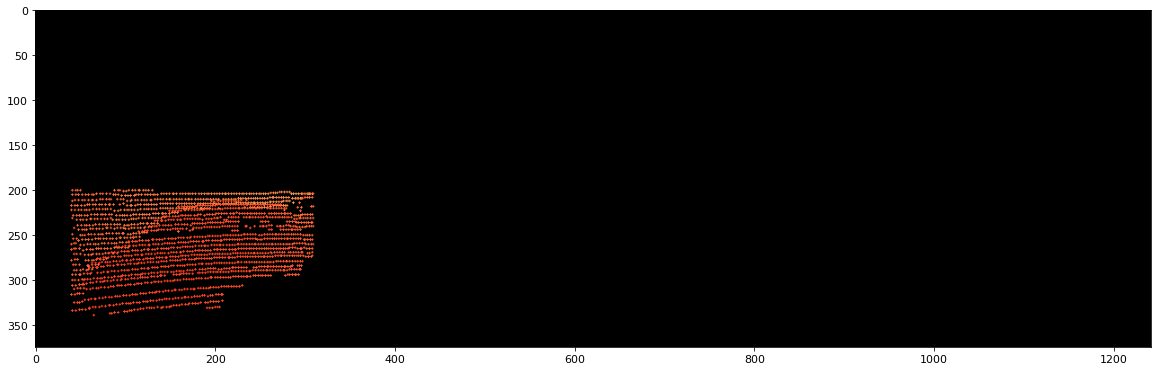

In [ ]:
new_image = np.zeros_like(left_image)
new_image = draw_velo_on_image(obj1_velo_camera, new_image)

plt.imshow(new_image);

In [ ]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=5, min_samples=5)

model.fit(obj1_velo_camera.T)

DBSCAN(eps=5)

In [ ]:
np.unique(model.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

In [ ]:
velo_camera.T.max(axis=0)

array([     1241.9,      374.99,      78.473])

In [ ]:
np.vstack((bboxes_out[:, 7], bboxes_out[:, 6], bboxes_out[:, 8])).T

array([[     170.92,      273.22,      8.4331],
       [     1180.8,      204.98,      12.768],
       [     329.19,      235.58,      13.057],
       [     442.15,      231.49,      13.397],
       [     503.98,      203.47,      20.855],
       [     877.66,      227.42,      10.472],
       [     671.39,      194.93,      33.416],
       [     568.22,      195.92,      71.531],
       [     814.91,      238.17,      11.769],
       [     882.25,      252.16,      10.521],
       [     628.75,      193.53,      47.248],
       [     758.63,      212.79,       20.02],
       [     612.88,      181.27,      76.168],
       [     758.63,      212.79,       20.02],
       [      539.6,      205.41,      29.514],
       [     400.11,      214.59,      20.223],
       [     541.91,      192.83,      31.222]])

In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=17, init=np.vstack((bboxes_out[:, 7], bboxes_out[:, 6], bboxes_out[:, 8])).T)
# model.init(bboxes_out[:, 6:8])
model.fit(velo_camera.T)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


KMeans(init=array([[     170.92,      273.22,      8.4331],
       [     1180.8,      204.98,      12.768],
       [     329.19,      235.58,      13.057],
       [     442.15,      231.49,      13.397],
       [     503.98,      203.47,      20.855],
       [     877.66,      227.42,      10.472],
       [     671.39,      194.93,      33.416],
       [     568.22,      195.92,      71.531],
       [     814.91,      238.17,      11.769],
       [     882.25,      252.16,      10.521],
       [     628.75,      193.53,      47.248],
       [     758.63,      212.79,       20.02],
       [     612.88,      181.27,      76.168],
       [     758.63,      212.79,       20.02],
       [      539.6,      205.41,      29.514],
       [     400.11,      214.59,      20.223],
       [     541.91,      192.83,      31.222]]),
       n_clusters=17)

In [ ]:
np.unique(model.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16], dtype=int32)

In [ ]:
# p#astel = cm.get_cmap('hsv')
# get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

# unpack LiDAR points
u, v, z = velo_camera # obj1_velo_camera
labels = model.labels_

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(u)):
    if labels[i] == 15:
        cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
                  get_pastel(labels[i]), -1);

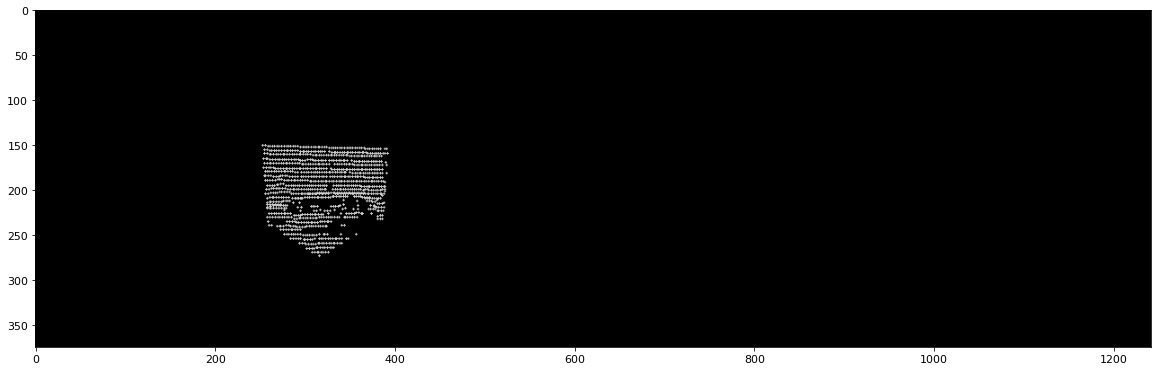

In [ ]:
plt.imshow(new_image);

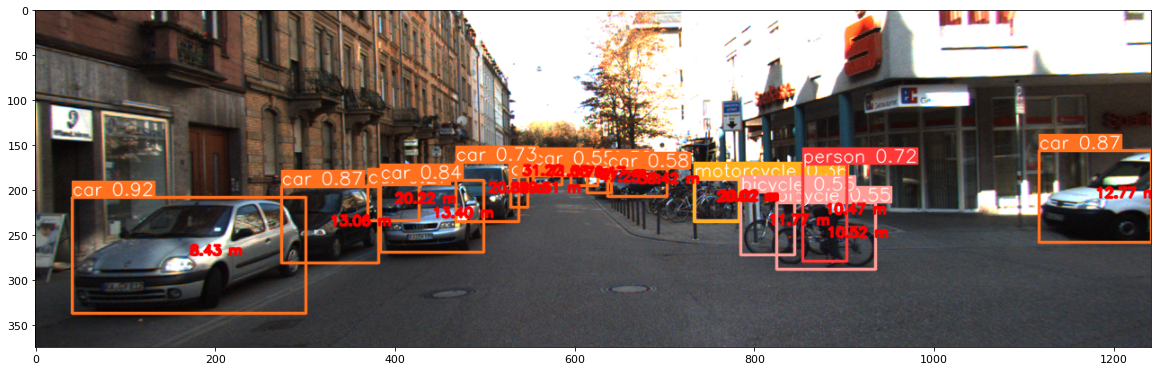

In [ ]:
plt.imshow(left_image)

In [ ]:
obj1_velo_camera[1, :].shape

(2217,)

In [ ]:
pastel = cm.get_cmap('hsv')
get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

# unpack LiDAR points
u, v, z = obj1_velo_camera
labels = model.labels_

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(u)):
    cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
               get_pastel(labels[i]), -1);

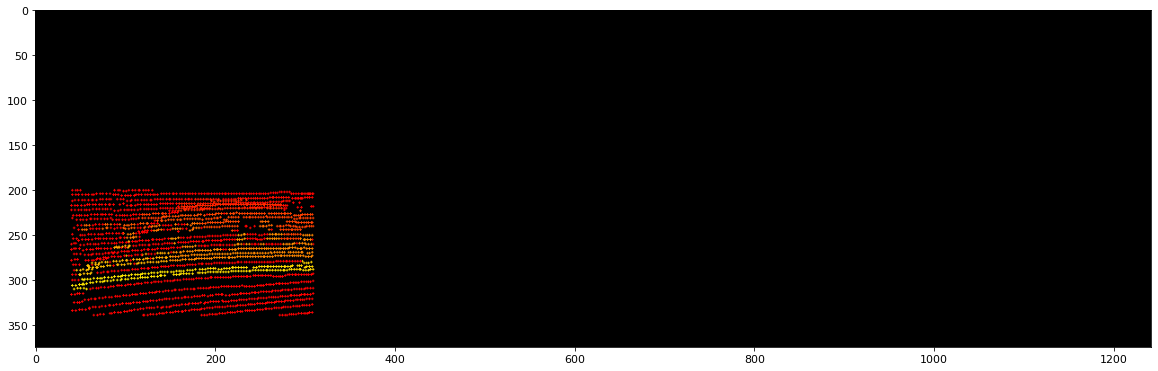

In [ ]:
plt.imshow(new_image);

## Now we can try to use PCA to get principle axes of the object of interest

## **Now make a full pipeline**
This pipeline will input a stereo pair along with a LiDAR point cloud. It will compute stereo depth and log error info

## **Now let's run the depth check on another sample of KITTI data!**

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

--2022-08-28 18:56:13--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.168.92
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.168.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  10.8MB/s    in 4m 36s  

2022-08-28 19:00:50 (10.7 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]



In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2022-08-28 19:00:51--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.151
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2022-08-28 19:00:52 (58.0 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]



In [ ]:
!jar xf 2011_10_03_drive_0047_sync.zip

In [ ]:
!jar xf 2011_10_03_calib.zip

### Get the Calibration data

In [ ]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

# decompose projection matrices
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

In [ ]:
with open(r'2011_10_03/calib_velo_to_cam.txt', 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),
                        np.array([0, 0, 0, 1])))

In [ ]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837


## **Now let's make a video**

In [ ]:
error_metrics = []
result_video = []

for idx in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    right_image = cv2.cvtColor(cv2.imread(right_image_paths[idx]), cv2.COLOR_BGR2RGB)
    lidar_bin = bin_paths[idx]

    left_image, velo_camera, errors, centers = stereo_depth_pipeline(
                                                                left_image, 
                                                                right_image, 
                                                                lidar_bin, 
                                                                draw_boxes=True, 
                                                                method='median')
    
    # draw LiDAR point cloud on new blank image
    u, v, z = velo_camera
    new_image = np.zeros_like(left_image, dtype=np.uint8)
    for i in range(len(u)):
        cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
                  get_color(z[i]), -1);
    
    # stack frames
    stacked = np.vstack((left_image, new_image))

    # add to result video
    result_video.append(stacked)

    # ensure that errors were recorded
    if len(errors) > 0:
        error_metrics.append(errors)

# get width and height for video frames
h, w, _ = stacked.shape

out = cv2.VideoWriter('boxed_pointcloud_stack_2011_10_03.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

# or use mp4
# out = cv2.VideoWriter('boxed_pointcloud_stack_2011_10_03.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

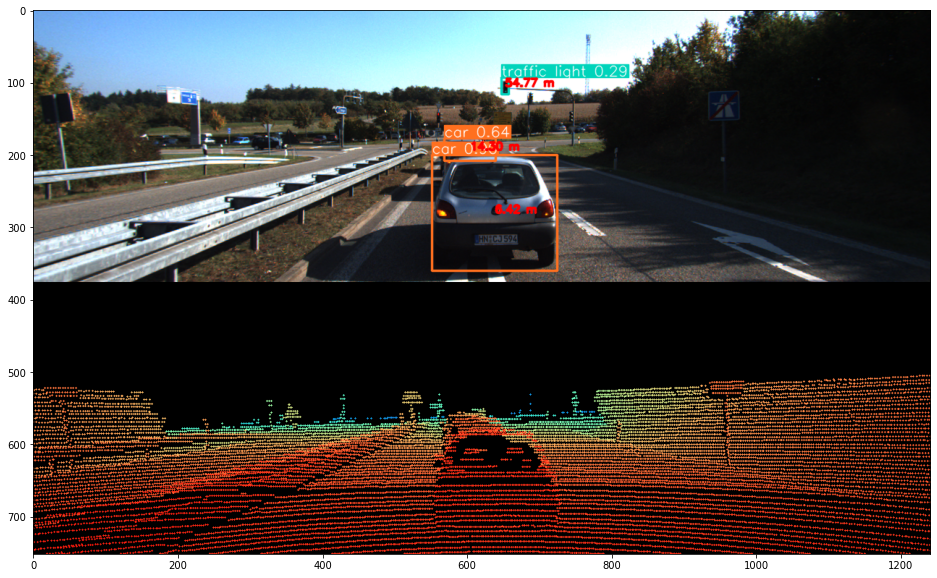

In [ ]:
plt.imshow(stacked);